In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
df = pd.read_parquet(filename)
df.head(5)

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,ophys_session_id,ophys_container_id,behavior_session_id,full_genotype,reporter_line,driver_line,indicator,sex,age_in_days,exposure_level
85,5,1086496689,"[0.06366926431655884, 0.002476318972185254, -0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.006115,-0.084113,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
86,5,1086501573,"[0.0637083426117897, 0.0919334813952446, -0.09...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.018832,-0.025578,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
87,5,1086500533,"[0.0223990511149168, 0.22551870346069336, 0.11...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.041275,-0.032698,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
88,5,1086497438,"[0.01795899122953415, 0.15271763503551483, 0.0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.039527,-0.026750,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
89,5,1086497908,"[0.059766266494989395, 0.03602207452058792, 0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.006628,-0.039277,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar


In [2]:
df.shape

(147695, 31)

In [3]:


# Parameters for ERP
pre_time = 1.0
post_time = 2.0
sampling_rate = 30
window_size = int((pre_time + post_time) * sampling_rate)
time_axis = np.linspace(-pre_time, post_time, window_size)

# ERP extraction function
def extract_aligned_trace(trace, timestamps, pre=1.0, post=2.0, target_time=0.0, baseline_correct=True):
    trace = np.array(trace)
    timestamps = np.array(timestamps)
    window_mask = (timestamps >= target_time - pre) & (timestamps <= target_time + post)
    if np.sum(window_mask) == 0:
        return None
    aligned_t = timestamps[window_mask] - target_time
    aligned_trace = trace[window_mask]
    interpolated = np.interp(time_axis, aligned_t, aligned_trace)
    if baseline_correct:
        baseline = np.mean(interpolated[time_axis < 0])
        interpolated -= baseline
    return interpolated

# Align and store trials
aligned_trials = []
for i, row in df.iterrows():
    if row['trace'] is None or row['trace_timestamps'] is None:
        continue
    aligned = extract_aligned_trace(row['trace'], row['trace_timestamps'], target_time=0.0)
    if aligned is None:
        continue
    aligned_trials.append({
        'aligned_trace': aligned,
        'cell_specimen_id': row['cell_specimen_id'],
        'cre_line': row['cre_line'],
        'omitted': row['omitted'],
        'exposure_level': row['exposure_level'],
        'ophys_session_id': row['ophys_session_id'],
        'ophys_container_id': row['ophys_container_id'],
        'mouse_id': row['mouse_id']
    })

erp_trials_df = pd.DataFrame(aligned_trials)

# Average per cell (ERP)
grouped = erp_trials_df.groupby(['cell_specimen_id', 'cre_line', 'omitted', 'exposure_level','mouse_id'])
averaged_erps = []
for keys, group in grouped:
    mean_trace = np.mean(np.stack(group['aligned_trace'].values), axis=0)
    averaged_erps.append({
        'cell_specimen_id': keys[0],
        'cre_line': keys[1],
        'omitted': keys[2],
        'exposure_level': keys[3],
        'mean_trace': mean_trace,
        'mouse_id': keys[4]
    })

erp_per_cell_df = pd.DataFrame(averaged_erps)
print("ERP-per-cell data created. Shape:", erp_per_cell_df.shape)
erp_per_cell_df.head()


ERP-per-cell data created. Shape: (640, 6)


,cell_specimen_id,cre_line,omitted,exposure_level,mean_trace,mouse_id
0,1086489847,Vip-IRES-Cre,False,familiar,"[-6.020262747345525e-05, -0.000311121364069539...",486737
1,1086489847,Vip-IRES-Cre,False,novel,"[0.0020884846416323213, 0.002512762204192922, ...",486737
2,1086489847,Vip-IRES-Cre,True,familiar,"[-0.0009402273595350087, -0.000707825894801432...",486737
3,1086489847,Vip-IRES-Cre,True,novel,"[-0.0032922540376090566, -0.003133170942153341...",486737
4,1086489860,Vip-IRES-Cre,False,familiar,"[-0.0043202691006240255, -0.004358619038064205...",486737


In [4]:
erp_per_cell_df['mouse_id'].nunique()

13

In [5]:
erp_per_cell_df.to_csv("erp_per-cell___.csv", index=False)

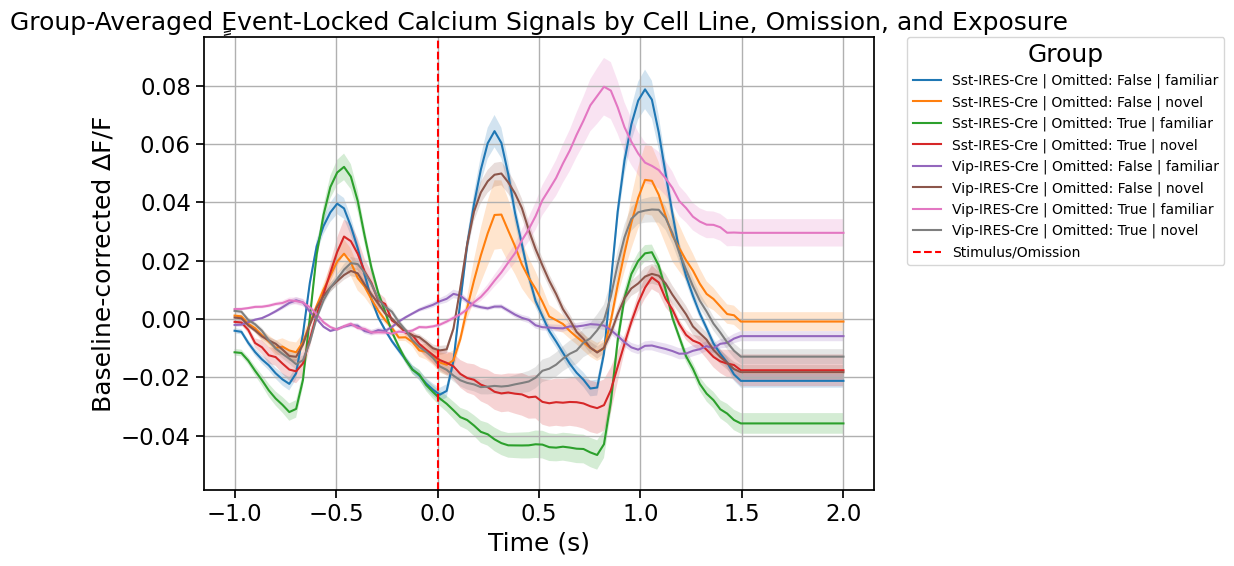

In [6]:
def plot_group_erps_clean(df, title):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 6))

    for label, group in df.groupby(['cre_line', 'omitted', 'exposure_level']):
        traces = np.stack(group['mean_trace'].values)
        mean_trace = traces.mean(axis=0)
        sem_trace = traces.std(axis=0) / np.sqrt(traces.shape[0])

        label_str = f"{label[0]} | Omitted: {label[1]} | {label[2]}"
        plt.plot(time_axis, mean_trace, label=label_str)
        plt.fill_between(time_axis, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.2)

    plt.axvline(0, color='red', linestyle='--', label='Stimulus/Omission')
    plt.xlabel("Time (s)")
    plt.ylabel("Baseline-corrected ∆F/F")
    plt.title(title)
    plt.grid(True)

    # 🔁 Better legend: outside the plot, compact
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=10,
        title='Group'
    )

    plt.tight_layout()
    plt.show()

# ✅ Call the improved function
plot_group_erps_clean(erp_per_cell_df, "Group-Averaged ٍEvent-Locked Calcium Signals by Cell Line, Omission, and Exposure")


In [7]:
def plot_filtered_erps(
    df,
    title="Filtered Event-Locked Calcium Signals Plot",
    cre_line=None,
    omitted=None,
    exposure_level=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    # Filter the DataFrame
    filtered = df.copy()
    if cre_line is not None:
        filtered = filtered[filtered['cre_line'] == cre_line]
    if omitted is not None:
        filtered = filtered[filtered['omitted'] == omitted]
    if exposure_level is not None:
        filtered = filtered[filtered['exposure_level'] == exposure_level]

    if filtered.empty:
        print("⚠️ No data matched your filtering criteria.")
        return

    # Plotting
    plt.figure(figsize=(10, 5))

    for cell_id, row in filtered.groupby('cell_specimen_id'):
        trace = np.array(row.iloc[0]['mean_trace'])  # only one row per cell per condition
        plt.plot(time_axis, trace, alpha=0.3, color='gray')

    # Plot mean ± SEM
    all_traces = np.stack(filtered['mean_trace'].values)
    mean_trace = all_traces.mean(axis=0)
    sem_trace = all_traces.std(axis=0) / np.sqrt(all_traces.shape[0])
    plt.plot(time_axis, mean_trace, color='blue', label='Mean Event-Locked Calcium Signals')
    plt.fill_between(time_axis, mean_trace - sem_trace, mean_trace + sem_trace, color='blue', alpha=0.2)

    plt.axvline(0, color='red', linestyle='--', label='Stimulus/Omission')
    plt.xlabel("Time (s)")
    plt.ylabel("Baseline-corrected ∆F/F")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


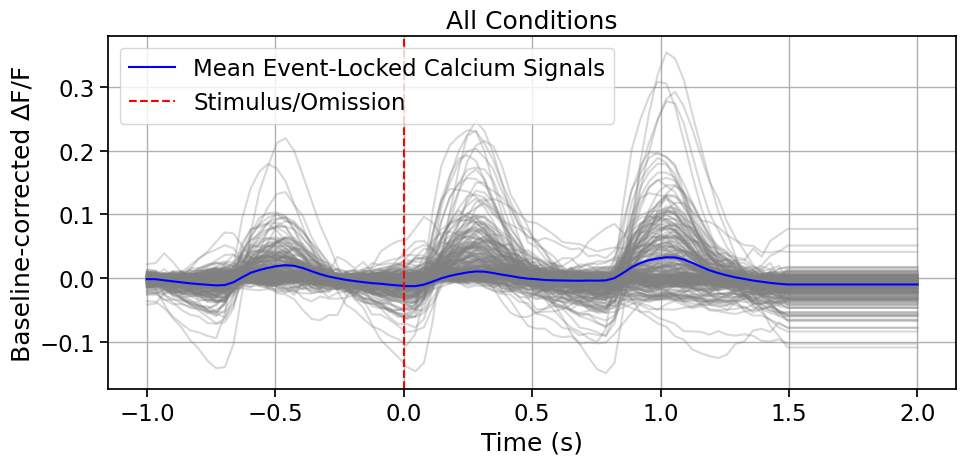

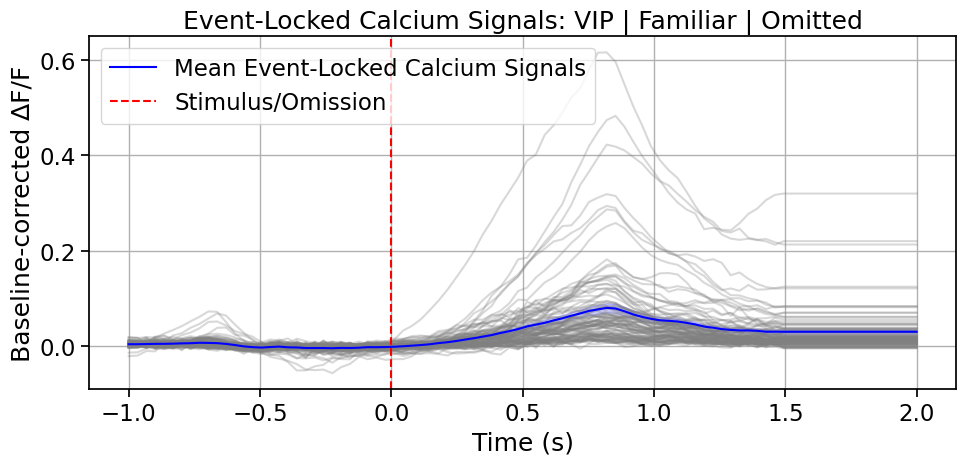

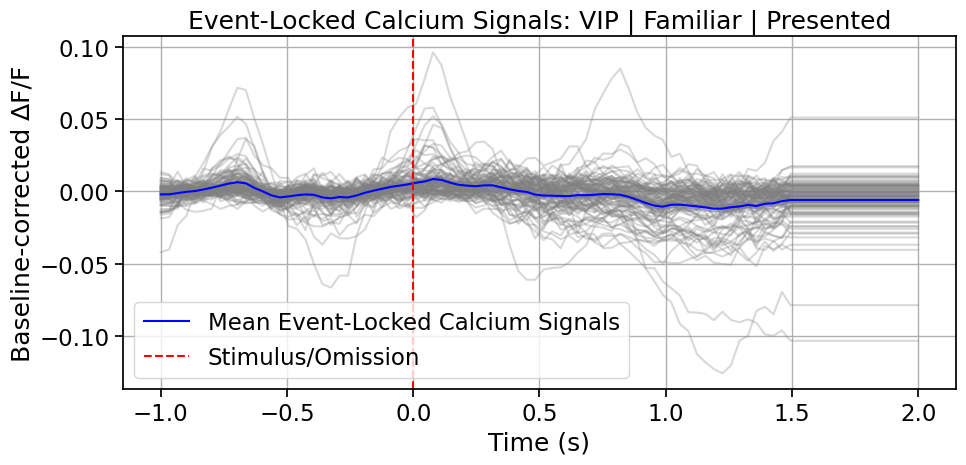

In [8]:
# 1. Plot all data
plot_filtered_erps(erp_per_cell_df, title="All Conditions")

# 2. VIP neurons, familiar images, omission trials
plot_filtered_erps(
    erp_per_cell_df,
    cre_line="Vip-IRES-Cre",
    omitted=True,
    exposure_level="familiar",
    title="Event-Locked Calcium Signals: VIP | Familiar | Omitted"
)

# 3. SST neurons, presented images, novel exposure
plot_filtered_erps(
    erp_per_cell_df,
    cre_line="Vip-IRES-Cre",
    omitted=False,
    exposure_level="familiar",
    title="Event-Locked Calcium Signals: VIP | Familiar | Presented"
)


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd

def get_aligned_matrix(df,
                       cre_line='Vip-IRES-Cre',
                       omitted=True,
                       exposure='familiar',
                       normalize='zscore'):
    """
    Filters the DataFrame by neuron type, omission, and exposure level,
    then extracts and normalizes aligned ∆F/F traces.

    Parameters:
        df (pd.DataFrame): DataFrame with 'aligned_trace' and metadata.
        cre_line (str): Cell type (e.g., 'Vip-IRES-Cre' or 'Sst-IRES-Cre').
        omitted (bool): Whether to include omitted trials.
        exposure (str): 'familiar' or 'novel' stimulus condition.
        normalize (str): 'zscore', 'minmax', or None.

    Returns:
        np.ndarray: Normalized mean traces (n_samples x time).
        pd.DataFrame: Metadata (cell ID, mouse ID, session ID, cluster placeholder).
    """
    required_cols = ['mean_trace', 'cell_specimen_id']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    subset = df[
        (df['cre_line'] == cre_line) &
        (df['omitted'] == omitted) &
        (df['exposure_level'] == exposure) &
        (df['mean_trace'].notnull())
    ].copy()

    if subset.empty:
        raise ValueError("No data matched the filter criteria.")

    try:
        traces = np.stack(subset['mean_trace'].values)
    except Exception as e:
        raise ValueError("Error stacking mean traces:") from e

    # Normalize traces
    if normalize == 'zscore':
        scaler = StandardScaler()
        normalized_traces = scaler.fit_transform(traces)
    elif normalize == 'minmax':
        scaler = MinMaxScaler()
        normalized_traces = scaler.fit_transform(traces)
    else:
        normalized_traces = traces  # no normalization

    metadata = subset[['cell_specimen_id'  ]].reset_index(drop=True)

    return normalized_traces, metadata
# Assuming 'erp_per_cell_df' contains the aligned_trace column
normalized_traces, metadata = get_aligned_matrix(
    df=erp_per_cell_df,
    cre_line='Vip-IRES-Cre',
    omitted=True,
    exposure='familiar',
    normalize='zscore'
)



In [10]:
a=pd.DataFrame(normalized_traces)
a.shape

(99, 90)

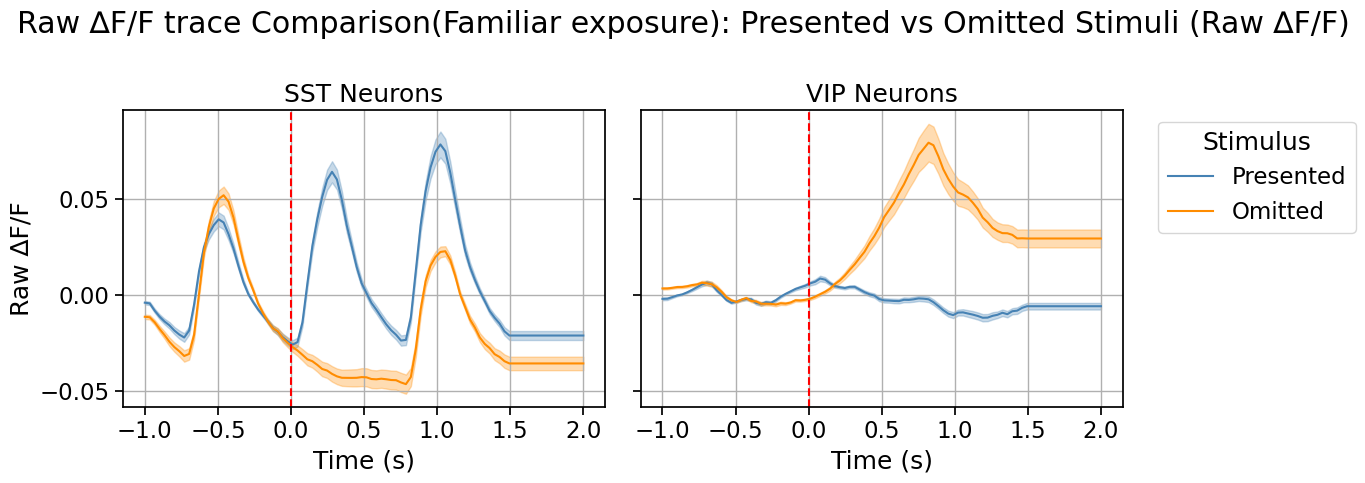

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract raw ∆F/F traces
def get_raw_traces(df, cre, omit, exposure):
    traces, metadata = get_aligned_matrix(
        df=df,
        cre_line=cre,
        omitted=omit,
        exposure=exposure,
        normalize=None
    )
    return traces

# Setup figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Define condition groups
conditions = {
    "SST": {
        "Presented": get_raw_traces(erp_per_cell_df, 'Sst-IRES-Cre', False, 'familiar'),
        "Omitted": get_raw_traces(erp_per_cell_df, 'Sst-IRES-Cre', True, 'familiar'),
    },
    "VIP": {
        "Presented": get_raw_traces(erp_per_cell_df, 'Vip-IRES-Cre', False, 'familiar'),
        "Omitted": get_raw_traces(erp_per_cell_df, 'Vip-IRES-Cre', True, 'familiar'),
    }
}

# Define consistent colors
colors = {
    "Presented": "steelblue",
    "Omitted": "darkorange"
}

# Plot each cell type
for ax, (cell_type, conds) in zip(axs, conditions.items()):
    for label, traces in conds.items():
        mean_trace = traces.mean(axis=0)
        sem_trace = traces.std(axis=0) / np.sqrt(traces.shape[0])
        ax.plot(time_axis, mean_trace, label=label, color=colors[label])
        ax.fill_between(time_axis, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3, color=colors[label])
    
    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f"{cell_type} Neurons")
    ax.set_xlabel("Time (s)")
    ax.grid(True)

# Final touches
axs[0].set_ylabel("Raw ∆F/F")
axs[1].legend(title="Stimulus", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("Raw ∆F/F trace Comparison(Familiar exposure): Presented vs Omitted Stimuli (Raw ∆F/F)")
plt.tight_layout()
plt.show()


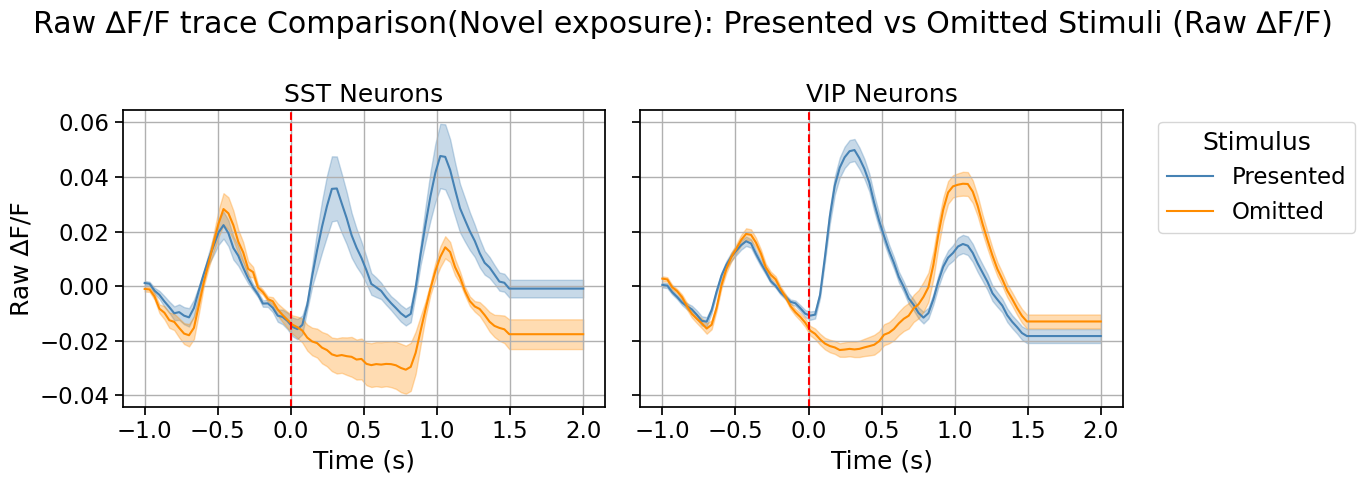

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract raw ∆F/F traces
def get_raw_traces(df, cre, omit, exposure):
    traces, metadata = get_aligned_matrix(
        df=df,
        cre_line=cre,
        omitted=omit,
        exposure=exposure,
        normalize=None
    )
    return traces

# Setup figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Define condition groups
conditions = {
    "SST": {
        "Presented": get_raw_traces(erp_per_cell_df, 'Sst-IRES-Cre', False, 'novel'),
        "Omitted": get_raw_traces(erp_per_cell_df, 'Sst-IRES-Cre', True, 'novel'),
    },
    "VIP": {
        "Presented": get_raw_traces(erp_per_cell_df, 'Vip-IRES-Cre', False, 'novel'),
        "Omitted": get_raw_traces(erp_per_cell_df, 'Vip-IRES-Cre', True, 'novel'),
    }
}

# Define consistent colors
colors = {
    "Presented": "steelblue",
    "Omitted": "darkorange"
}

# Plot each cell type
for ax, (cell_type, conds) in zip(axs, conditions.items()):
    for label, traces in conds.items():
        mean_trace = traces.mean(axis=0)
        sem_trace = traces.std(axis=0) / np.sqrt(traces.shape[0])
        ax.plot(time_axis, mean_trace, label=label, color=colors[label])
        ax.fill_between(time_axis, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3, color=colors[label])
    
    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f"{cell_type} Neurons")
    ax.set_xlabel("Time (s)")
    ax.grid(True)

# Final touches
axs[0].set_ylabel("Raw ∆F/F")
axs[1].legend(title="Stimulus", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("Raw ∆F/F trace Comparison(Novel exposure): Presented vs Omitted Stimuli (Raw ∆F/F)")
plt.tight_layout()
plt.show()


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_heatmap_of_erps(df, cre_line='Sst-IRES-Cre', omitted=True, exposure='familiar'):
    """
    Plot heatmap of mean ERP traces per cell, optionally sorted by peak latency.
    """
    subset = df[
        (df['cre_line'] == cre_line) &
        (df['omitted'] == omitted) &
        (df['exposure_level'] == exposure)
    ]

    if subset.empty:
        print("⚠️ No data found for the specified filters.")
        return

    # Convert mean_trace values to a matrix
    traces = np.stack(subset['mean_trace'].values)

    # Sort by peak latency (optional)
    peak_idx = np.argmax(traces, axis=1)
    sort_idx = np.argsort(peak_idx)
    sorted_traces = traces[sort_idx]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(sorted_traces, cmap="viridis", cbar_kws={'label': '∆F/F'}, robust=True)

    # X-axis ticks in seconds
    xticks = np.linspace(0, len(time_axis) - 1, 5).astype(int)
    plt.xticks(xticks, [f"{time_axis[i]:.1f}" for i in xticks])

    plt.xlabel("Time (s)")
    plt.ylabel("Cells (sorted by peak latency)")
    plt.title(f"Event-Locked Calcium Signals Heatmap | {cre_line} | Omitted: {omitted} | {exposure.capitalize()}")
    plt.tight_layout()
    plt.show()


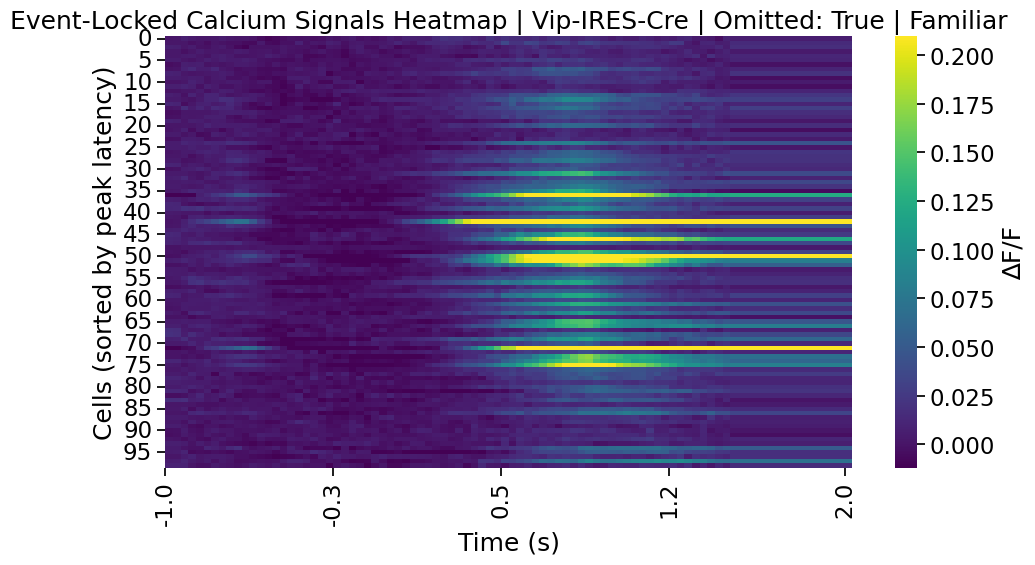

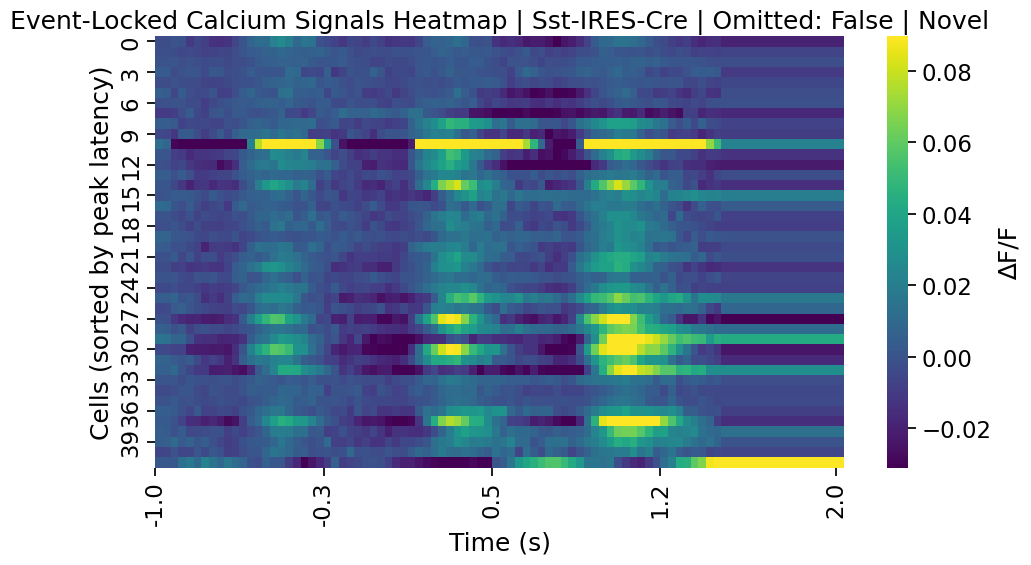

In [14]:
# Plot for VIP neurons, omission trials, familiar exposure
plot_heatmap_of_erps(erp_per_cell_df, cre_line='Vip-IRES-Cre', omitted=True, exposure='familiar')

# Plot for SST neurons, presented trials, novel exposure
plot_heatmap_of_erps(erp_per_cell_df, cre_line='Sst-IRES-Cre', omitted=False, exposure='novel')


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joypy

def ridge_plot_fixed_scale(df, cre_line='Sst-IRES-Cre', omitted=True, exposure='familiar', xlim=(-0.5, 0.5)):
    subset = df[(df['cre_line'] == cre_line) &
                (df['omitted'] == omitted) &
                (df['exposure_level'] == exposure)]

    if subset.empty:
        print("No data available.")
        return

    traces = np.stack(subset['mean_trace'].values)
    df_ridge = pd.DataFrame(traces.T, index=time_axis)

    fig, axes = joypy.joyplot(
        df_ridge.iloc[:, :30],
        overlap=0.6,
        figsize=(10, 8),
        colormap=plt.cm.viridis,
        x_range=xlim  # ✅ set x-axis range here
    )

    axes[-1].set_title(f"Ridge Plot of Event-Locked Calcium Signals\n{cre_line} | Omitted: {omitted} | Exposure: {exposure}")
    axes[-1].set_xlabel("∆F/F")
    axes[-1].set_xlim(xlim)  # ✅ ensure consistent x-axis scale
    plt.tight_layout()
    plt.show()


C:\Users\Saye\AppData\Local\Temp\ipykernel_14212\1121329385.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


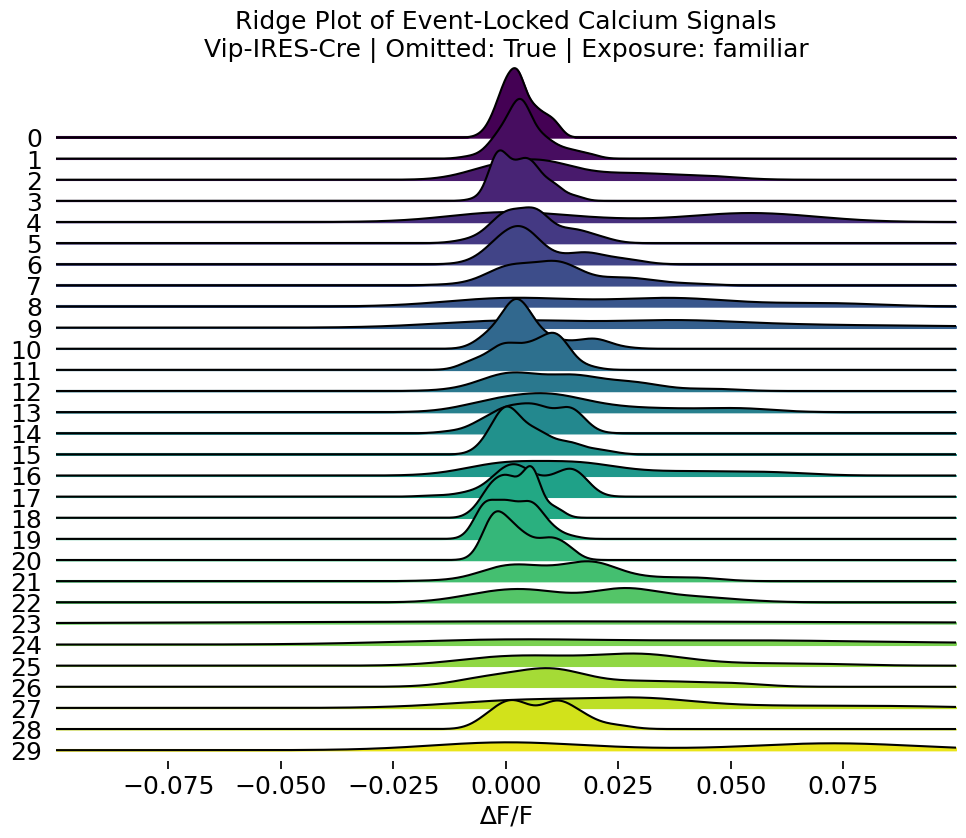

C:\Users\Saye\AppData\Local\Temp\ipykernel_14212\1121329385.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


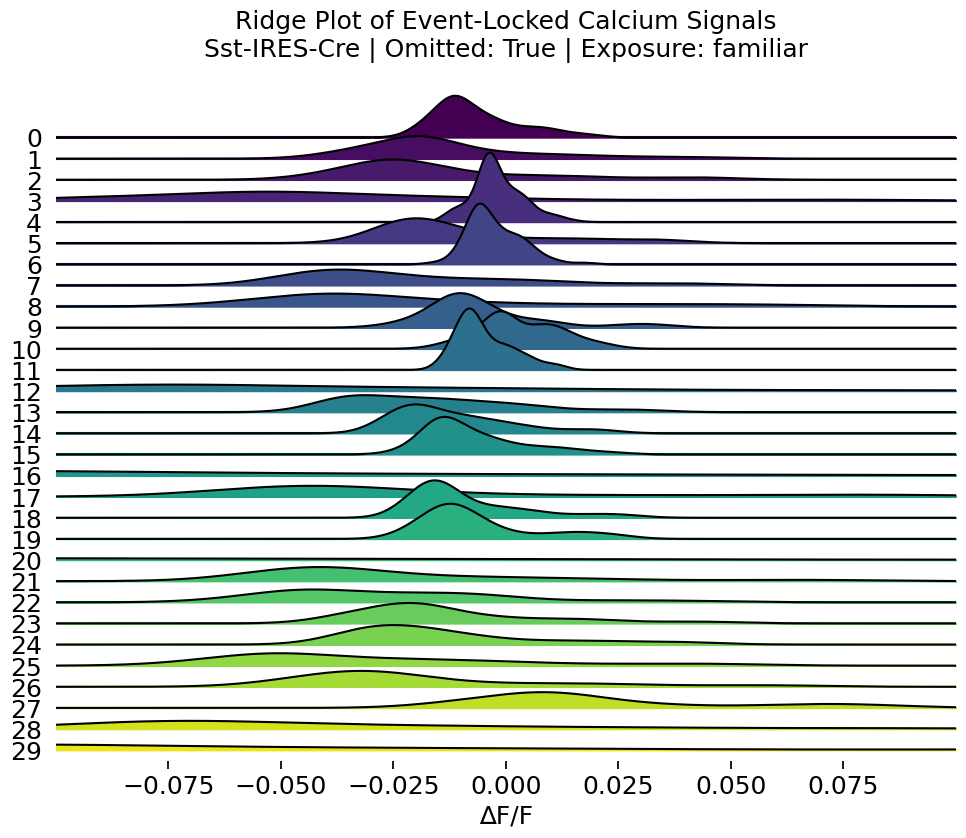

In [16]:

ridge_plot_fixed_scale(erp_per_cell_df, cre_line='Vip-IRES-Cre', omitted=True, exposure='familiar', xlim=(-0.1, 0.1))
ridge_plot_fixed_scale(erp_per_cell_df, cre_line='Sst-IRES-Cre', omitted=True, exposure='familiar', xlim=(-0.1, 0.1))



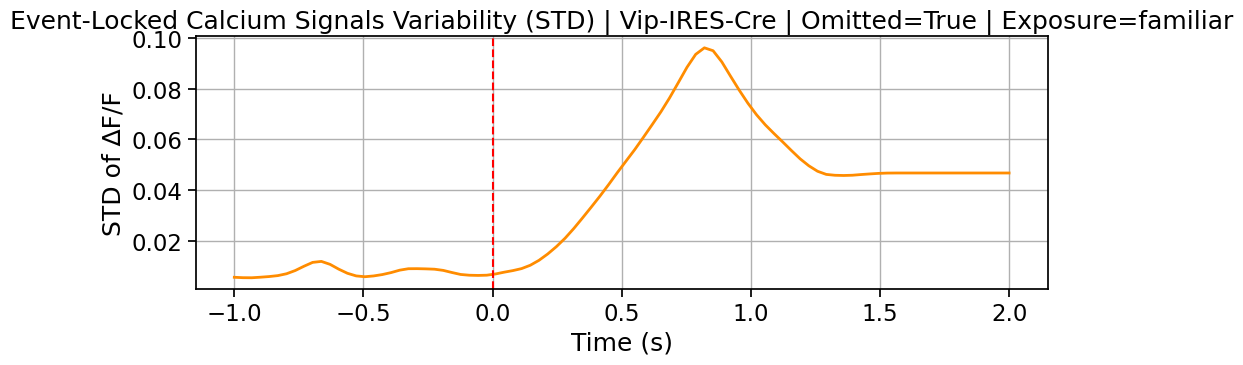

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_erp_variability(df, cre_line='Sst-IRES-Cre', omitted=True, exposure='familiar', smooth=True, sigma=1.0):
    # Filter data
    subset = df[(df['cre_line'] == cre_line) &
                (df['omitted'] == omitted) &
                (df['exposure_level'] == exposure)]

    if subset.empty:
        print("❌ No data available for given filters.")
        return

    # Stack and compute std
    traces = np.stack(subset['mean_trace'].values)
    std_trace = np.std(traces, axis=0)

    if smooth:
        std_trace = gaussian_filter1d(std_trace, sigma=sigma)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, std_trace, color='darkorange', linewidth=2)
    plt.axvline(0, color='red', linestyle='--', label='Stimulus/Omission')
    plt.xlabel("Time (s)")
    plt.ylabel("STD of ∆F/F")
    plt.title(f"Event-Locked Calcium Signals Variability (STD) | {cre_line} | Omitted={omitted} | Exposure={exposure}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_erp_variability(erp_per_cell_df, cre_line='Vip-IRES-Cre', omitted=True, exposure='familiar')


In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def pca_erp_projection(df, cre_line='Sst-IRES-Cre', omitted=True, exposure='familiar'):
    # Filter the dataframe
    subset = df[(df['cre_line'] == cre_line) &
                (df['omitted'] == omitted) &
                (df['exposure_level'] == exposure)]

    if subset.empty:
        print("❌ No data available for this group.")
        return

    # Replace 'aligned_trace' with 'mean_trace'
    traces = np.stack(subset['mean_trace'].values)

    # Apply PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(traces)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(pcs[:, 0], pcs[:, 1], alpha=0.6, edgecolor='k')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"PCA of Event-Locked Calcium  Traces\n{cre_line} | Omitted={omitted} | Exposure={exposure}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


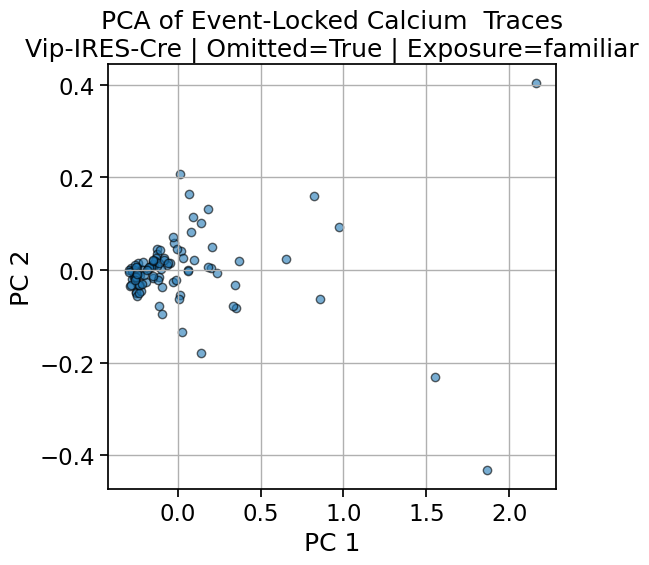

In [19]:
pca_erp_projection(erp_per_cell_df, cre_line='Vip-IRES-Cre', omitted=True, exposure='familiar')


In [20]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_erp_umap(df, color_by='cre_line'):
    subset = df.copy()

    # Convert mean_trace column to 2D array
    traces = np.stack(subset['mean_trace'].values)

    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(traces)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                    hue=subset[color_by], palette='tab10', s=60, alpha=0.8, edgecolor='k')
    plt.title(f"UMAP Projection of Event-Locked Calcium Signals (colored by '{color_by}')")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title=color_by, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
from sklearn.manifold import TSNE

def plot_erp_tsne(df, color_by='cre_line'):
    subset = df.copy()

    # Convert mean_trace column to 2D array
    traces = np.stack(subset['mean_trace'].values)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embedding = tsne.fit_transform(traces)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                    hue=subset[color_by], palette='tab10', s=60, alpha=0.8, edgecolor='k')
    plt.title(f"t-SNE Projection of ERPs (colored by '{color_by}')")
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.legend(title=color_by, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



e:\anaconda\envs\allendb-py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


e:\anaconda\envs\allendb-py310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


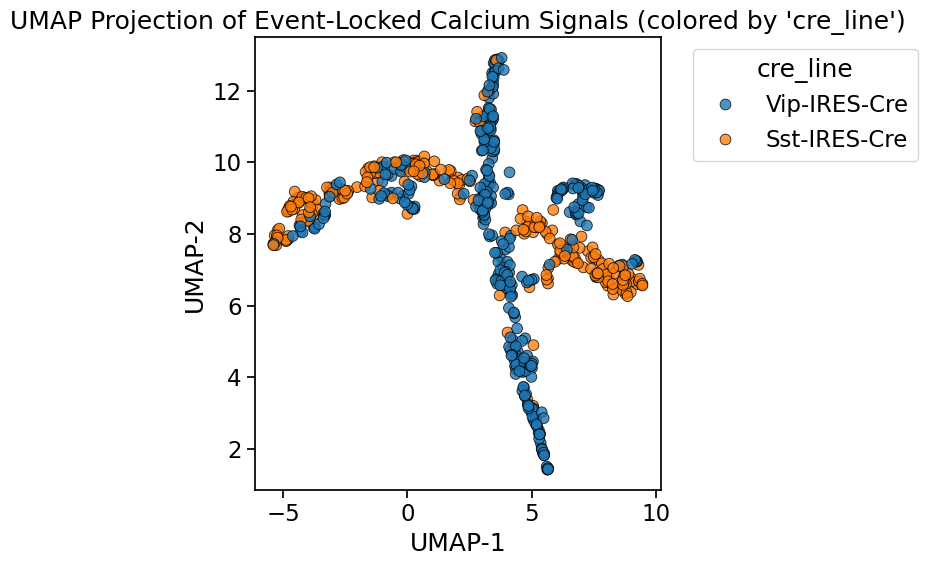

e:\anaconda\envs\allendb-py310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


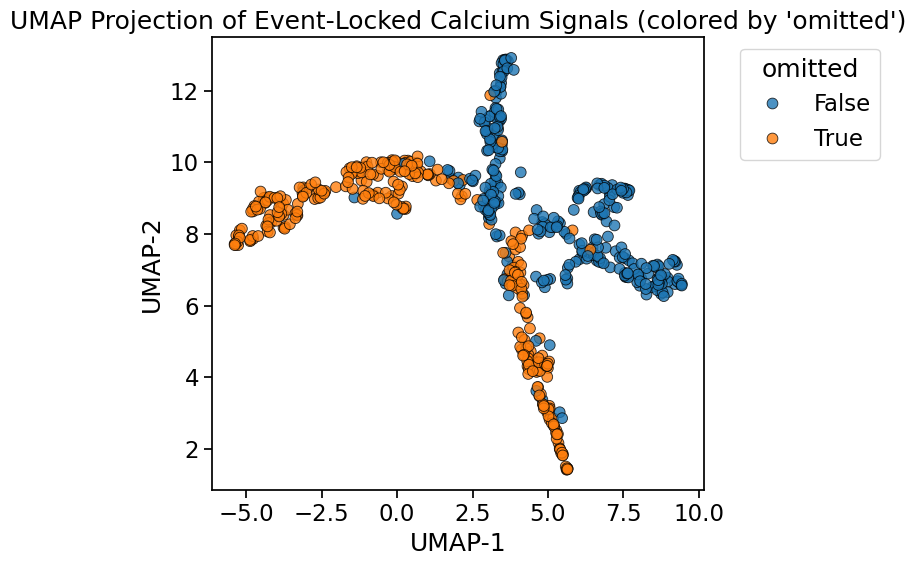

e:\anaconda\envs\allendb-py310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


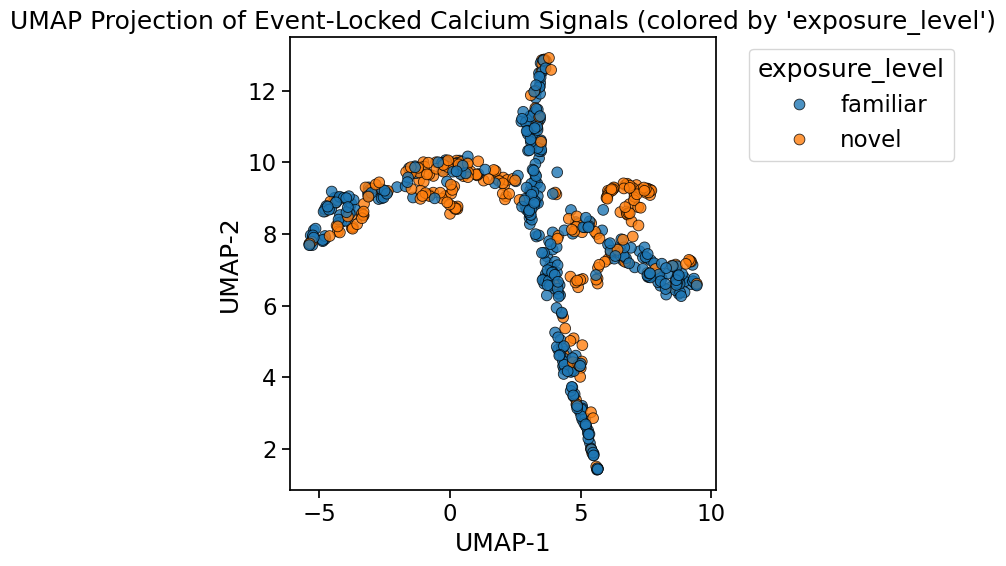

In [21]:
plot_erp_umap(erp_per_cell_df, color_by='cre_line')
#plot_erp_tsne(erp_per_cell_df, color_by='exposure_level')
plot_erp_umap(erp_per_cell_df, color_by='omitted')
plot_erp_umap(erp_per_cell_df, color_by='exposure_level')

In [22]:
import numpy as np
import pandas as pd
from scipy.integrate import simps
from scipy.stats import skew, kurtosis

def extract_erp_features_from_df(df, time_axis):
    features = []
    metadata = []

    # Time masks
    mask_0_500 = (time_axis >= 0) & (time_axis < 0.5)
    mask_500_1000 = (time_axis >= 0.5) & (time_axis < 1.0)
    mask_0_200 = (time_axis >= 0) & (time_axis <= 0.2)

    for _, row in df.iterrows():
        trace = np.array(row['mean_trace'])

        peak_amp = np.max(trace)
        peak_idx = np.argmax(trace)
        latency_to_peak = time_axis[peak_idx]

        trough_amp = np.min(trace)
        trough_idx = np.argmin(trace)
        latency_to_trough = time_axis[trough_idx]

        auc = simps(trace, time_axis)
        peak_to_trough = peak_amp - trough_amp

        try:
            x_fit = time_axis[mask_0_200]
            y_fit = trace[mask_0_200]
            slope, _ = np.polyfit(x_fit, y_fit, 1)
        except:
            slope = np.nan

        half_max = peak_amp / 2
        above_half = np.where(trace >= half_max)[0]
        fwhm = time_axis[above_half[-1]] - time_axis[above_half[0]] if len(above_half) >= 2 else 0

        energy = np.sum(trace ** 2)
        mean_0_500 = np.mean(trace[mask_0_500])
        mean_500_1000 = np.mean(trace[mask_500_1000])

        trace_skew = skew(trace)
        trace_kurt = kurtosis(trace)
        zero_crossings = np.sum(np.diff(np.sign(trace)) != 0)

        try:
            norm_trace = trace - np.min(trace)
            norm_trace /= np.max(norm_trace)
            rise_start = np.argmax(norm_trace >= 0.1)
            rise_end = np.argmax(norm_trace >= 0.9)
            rise_time = time_axis[rise_end] - time_axis[rise_start]
        except:
            rise_time = np.nan

        try:
            decay_start = peak_idx
            decay_half = np.argmax(trace[decay_start:] <= peak_amp / 2)
            decay_time = time_axis[decay_start + decay_half] - time_axis[decay_start]
        except:
            decay_time = np.nan

        features.append({
            "AUC": auc,
            "PeakAmplitude": peak_amp,
            "LatencyToPeak": latency_to_peak,
            "TroughAmplitude": trough_amp,
            "LatencyToTrough": latency_to_trough,
            "PeakToTrough": peak_to_trough,
            "Slope_0_200ms": slope,
            "FWHM": fwhm,
            "Energy": energy,
            "Mean_0_500ms": mean_0_500,
            "Mean_500_1000ms": mean_500_1000,
            "Skewness": trace_skew,
            "Kurtosis": trace_kurt,
            "ZeroCrossings": zero_crossings,
            "RiseTime_10to90": rise_time,
            "DecayTime_Half": decay_time
        })

        metadata.append({
            "cell_specimen_id": row["cell_specimen_id"],
            "cre_line": row["cre_line"],
            "omitted": row["omitted"],
            "exposure_level": row["exposure_level"],
            'mouse_id' : row['mouse_id']
        })

    df_features = pd.DataFrame(features)
    df_meta = pd.DataFrame(metadata)
    return pd.concat([df_meta, df_features], axis=1)


In [23]:
erp_feature_df = extract_erp_features_from_df(erp_per_cell_df, time_axis)

erp_feature_df

,cell_specimen_id,cre_line,omitted,exposure_level,mouse_id,AUC,PeakAmplitude,LatencyToPeak,TroughAmplitude,LatencyToTrough,...,Slope_0_200ms,FWHM,Energy,Mean_0_500ms,Mean_500_1000ms,Skewness,Kurtosis,ZeroCrossings,RiseTime_10to90,DecayTime_Half
0,1086489847,Vip-IRES-Cre,False,familiar,486737,0.001156,0.006611,0.314607,-0.003816,1.022472,...,-0.003303,0.842697,0.000512,0.003253,0.001879,0.529877,-0.219510,20,1.314607,0.168539
1,1086489847,Vip-IRES-Cre,False,novel,486737,0.018161,0.027589,0.584270,-0.006884,0.078652,...,0.046827,0.977528,0.010294,0.010388,0.014589,0.777351,-0.457898,11,1.449438,0.202247
2,1086489847,Vip-IRES-Cre,True,familiar,486737,0.008858,0.011794,0.820225,-0.005546,-0.224719,...,-0.017613,0.910112,0.002140,0.000194,0.008266,0.416573,-0.407229,9,1.719101,0.235955
3,1086489847,Vip-IRES-Cre,True,novel,486737,0.002576,0.015562,1.056180,-0.006281,0.280899,...,-0.009213,1.584270,0.002281,-0.003856,-0.000034,1.020190,0.469992,9,2.056180,0.303371
4,1086489860,Vip-IRES-Cre,False,familiar,486737,0.000282,0.008663,-0.730337,-0.011890,1.258427,...,-0.022773,1.483146,0.001259,0.002677,0.003004,-0.162385,0.566323,14,0.269663,0.101124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1086668399,Sst-IRES-Cre,True,familiar,489056,-0.010611,0.013527,-0.528090,-0.015054,0.382022,...,-0.003752,1.719101,0.005462,-0.008501,-0.004693,0.618474,-0.478573,10,0.438202,0.168539
636,1086668409,Sst-IRES-Cre,False,familiar,489056,0.037309,0.079627,0.280899,-0.024216,-0.089888,...,0.497442,1.044944,0.095560,0.037566,0.022881,0.888498,-0.480872,7,1.247191,0.168539
637,1086668409,Sst-IRES-Cre,True,familiar,489056,-0.056527,0.052847,-0.460674,-0.060499,0.752809,...,0.012553,1.685393,0.104130,-0.041049,-0.032632,0.940881,-0.160731,4,0.438202,0.101124
638,1086668440,Sst-IRES-Cre,False,familiar,489056,0.004663,0.024962,0.988764,-0.011260,-0.831461,...,0.132752,1.617978,0.006963,0.007394,0.001179,0.948147,-0.042974,16,1.988764,0.134831


In [24]:
erp_feature_df['mouse_id'].nunique()

13

In [25]:
erp_feature_df.to_csv("erp_per-cell_features_extracted.csv", index=False)

In [26]:
# Count NaNs per column
nan_summary = erp_feature_df.isna().sum()
print(nan_summary[nan_summary > 0])

Series([], dtype: int64)


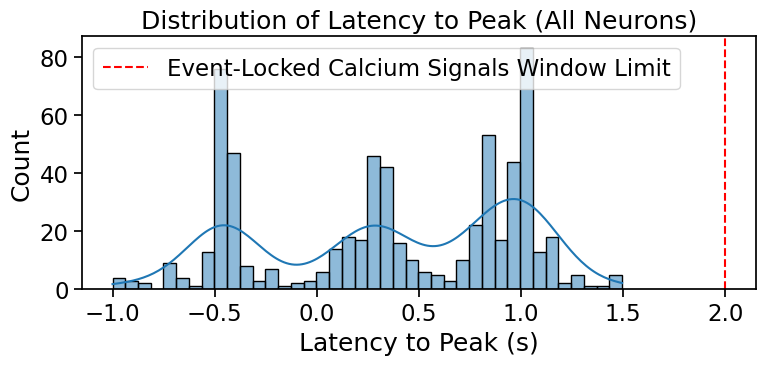

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(erp_feature_df['LatencyToPeak'], bins=40, kde=True)
plt.axvline(2.0, color='red', linestyle='--', label='Event-Locked Calcium Signals Window Limit')
plt.title("Distribution of Latency to Peak (All Neurons)")
plt.xlabel("Latency to Peak (s)")
plt.legend()
plt.tight_layout()
plt.show()

## 

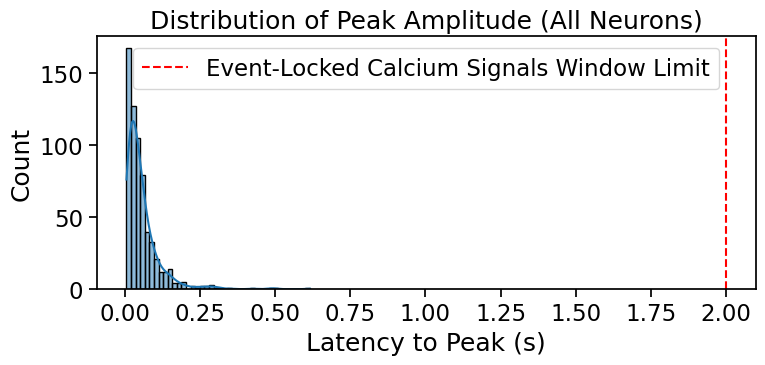

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(erp_feature_df['PeakAmplitude'], bins=40, kde=True)
plt.axvline(2.0, color='red', linestyle='--', label='Event-Locked Calcium Signals Window Limit')
plt.title("Distribution of Peak Amplitude (All Neurons)")
plt.xlabel("Latency to Peak (s)")
plt.legend()
plt.tight_layout()
plt.show()

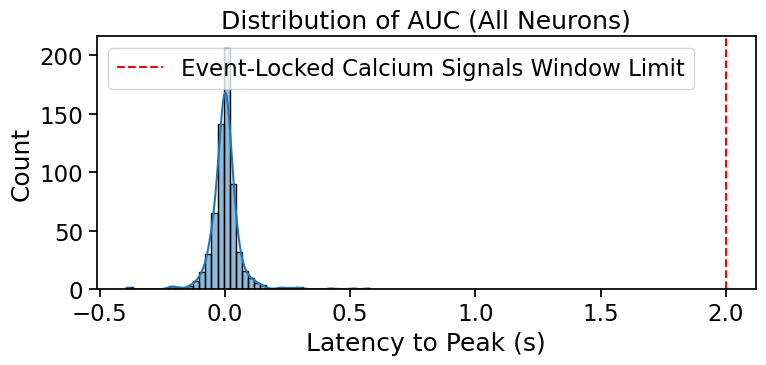

In [29]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(erp_feature_df['AUC'], bins=40, kde=True)
plt.axvline(2.0, color='red', linestyle='--', label='Event-Locked Calcium Signals Window Limit')
plt.title("Distribution of AUC (All Neurons)")
plt.xlabel("Latency to Peak (s)")
plt.legend()
plt.tight_layout()
plt.show()